<a href="https://colab.research.google.com/github/elliotgengler/Option-DeAmericanization/blob/main/FirstPricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [3]:
def digits_right(guess,actual):
  return -math.log10(abs(guess-actual))

def print_eval(est,actual,start,stop,prec):
  print("Estimate:",round(est,prec))
  print("Error:",round(actual-est,prec))
  print("Digits Correct:",round(digits_right(est,actual),2))
  print("Time Elapsed (s):", round(stop-start,2))

# European Option Pricing

In [4]:
def payoff(S_0,N,j,u,d,K,is_call):
  S_t = S_0 * u**j * d**(N-j) # up j times, down N-j times
  if is_call:
    return max(S_t-K,0)
  else:
    return max(K-S_t,0)

def p_riskneutral(r,q,delta_time,u,d):
  return (math.exp((r-q)*delta_time)-d)/(u-d)

def euro(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  sum = 0
  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  for j in range(N+1):
    sum += math.comb(N,j) * pstar**j * (1-pstar)**(N-j) * payoff(S_0,N,j,u,d,K,is_call) # probability times payoff

  return sum * math.exp(-r*Maturity)

In [5]:
start = time.time()
est = euro(100,100,1,0.2,1000,0.05,0.02,True)
stop = time.time()
print_eval(est,9.2269939894,start,stop,6)

Estimate: 9.225062
Error: 0.001932
Digits Correct: 2.71
Time Elapsed (s): 0.03


# Backwards Induction

In [18]:
def backward_induce_euro(V,pstar,disc):
  U = pstar*V[1:] + (1-pstar)*V[:-1]
  return U*disc

def euro_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  disc = math.exp(-r*Maturity/N)

  V = np.zeros(N+1)
  for i in range(N+1):
    V[i] = payoff(S_0,N,i,u,d,K,is_call)  # initialize payoff at maturity

  for i in range(N):
    V = backward_induce_euro(V,pstar,disc)
  return V[0]

In [7]:
start = time.time()
est = euro_backward_induction(100,100,1,0.2,5000,0.05,0.02,True)
stop = time.time()

print_eval(est,9.2269939894,start,stop,6)

Estimate: 9.226617
Error: 0.000377
Digits Correct: 3.42
Time Elapsed (s): 0.07


## Performance


In [15]:
errors_dir = []
times_dir = []
for i in range(1,1001):
  start = time.time()
  errors_dir.append(euro(100,100,1,0.2,i,0.05,0.02,True)-9.2269939894)
  stop = time.time()
  times_dir.append(stop-start)

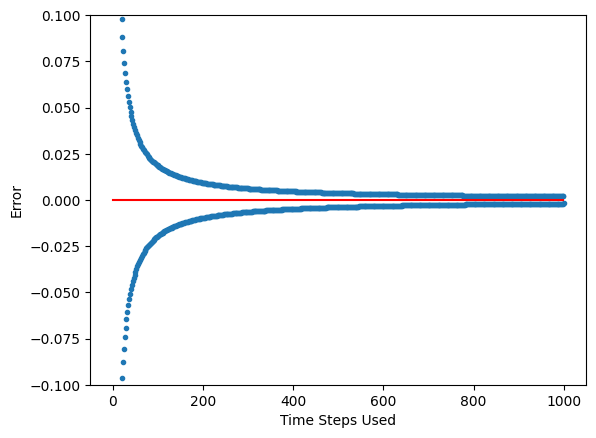

In [16]:
plt.scatter(range(1,1001),errors_dir,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.1,0.1]);

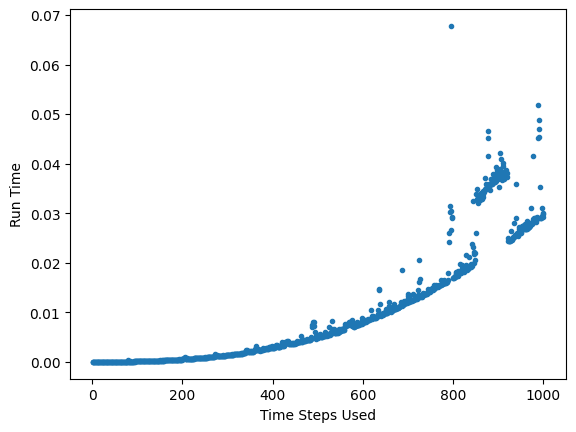

In [17]:
plt.scatter(range(1,1001),times_dir,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

In [29]:
errors_bi = []
times_bi = []
for i in range(1,1001):
  start = time.time()
  errors_bi.append(euro_backward_induction(100,100,1,0.2,i,0.05,0.02,True)-9.2269939894)
  stop = time.time()
  times_bi.append(stop-start)

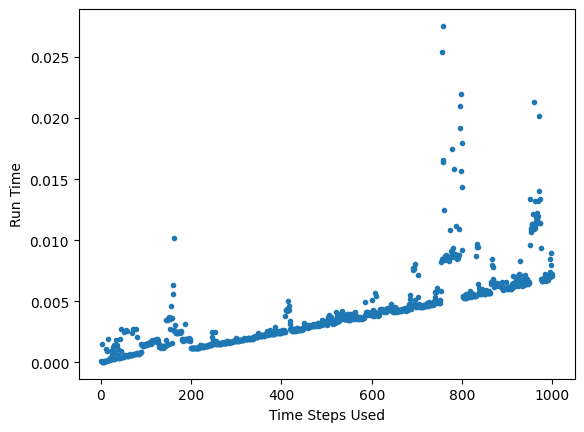

In [30]:
plt.scatter(range(1,1001),times_bi,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

## Averaging

In [31]:
def euro_averager(S_0,K,Maturity,sigma,N,r,q,is_call):
  a=euro_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call)
  b=euro_backward_induction(S_0,K,Maturity,sigma,N+1,r,q,is_call)
  return (a+b)/2

In [32]:
start = time.time()
est = euro_averager(100,100,1,0.2,5000,0.05,0.02,True)
stop = time.time()

print_eval(est,9.2269939894,start,stop,8)

Estimate: 9.22699569
Error: -1.7e-06
Digits Correct: 5.77
Time Elapsed (s): 0.15


In [33]:
errors_avg = []
times_avg = []
for i in range(1,1001):
  start = time.time()
  errors_avg.append(euro_averager(100,100,1,0.2,i,0.05,0.02,True)-9.2269939894)
  stop = time.time()
  times_avg.append(stop-start)

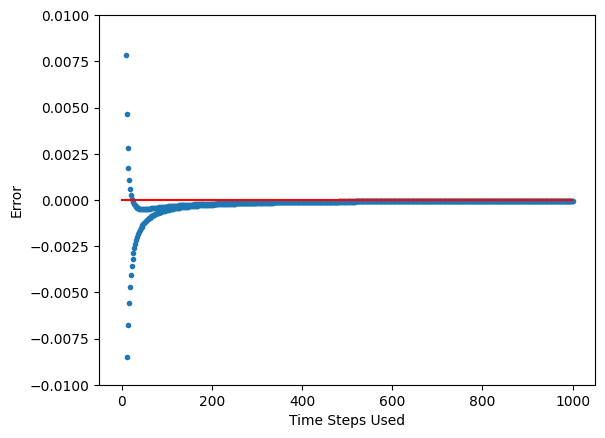

In [34]:
plt.scatter(range(1,1001),errors_avg,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.01,0.01]);

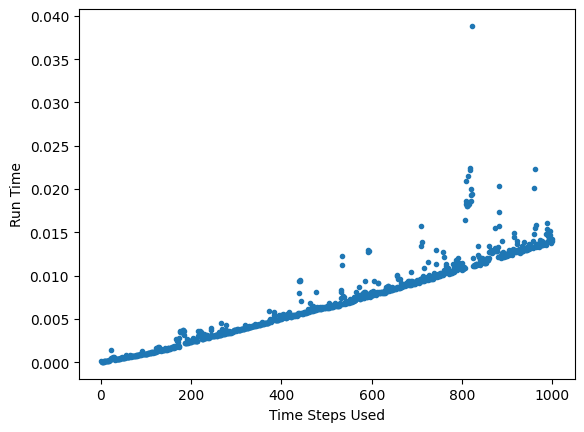

In [35]:
plt.scatter(range(1,1001),times_avg,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

# American Options

In [78]:
def backward_induce_american(V,S,u,pstar,disc,K,is_call):
  # perform one step of backward induction on state vectors V and S
  continuing_val = pstar*V[1:] + (1-pstar)*V[:-1] # same as with european
  S = S[:-1]*u # multiplying by u (or dividing by d) steps the stocks back a step
  if is_call:
    exercise_val = np.maximum(S-K,np.zeros(S.shape[0]))
  else:
    exercise_val = np.maximum(K-S,np.zeros(S.shape[0]))
  V = np.maximum(continuing_val,exercise_val) * disc
  return V, S

In [79]:
def american_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  disc = math.exp(-r*Maturity/N) # discount per time step

  V = np.zeros(N+1)
  S = np.zeros(N+1)
  for i in range(N+1):
    # initializing state vectors
    V[i] = payoff(S_0,N,i,u,d,K,is_call)
    S[i] = S_0*u**(i)*d**(N-i)

  for i in range(N):
    # N rounds of backward induction
    V,S = backward_induce_american(V,S,u,pstar,disc,K,is_call)
  return V[0]

In [81]:
start = time.time()
est = american_backward_induction(100,100,1,0.2,5000,0.05,0.02,False)
stop = time.time()

print_eval(est,6.66069,start,stop,6)

Estimate: 6.660436
Error: 0.000254
Digits Correct: 3.6
Time Elapsed (s): 0.12


# Convergence

In [87]:
errors_am = []
times_am = []
for i in range(1,1001):
  start = time.time()
  errors_am.append(american_backward_induction(100,100,1,0.2,i,0.05,0.02,False)-6.66069)
  stop = time.time()
  times_am.append(stop-start)

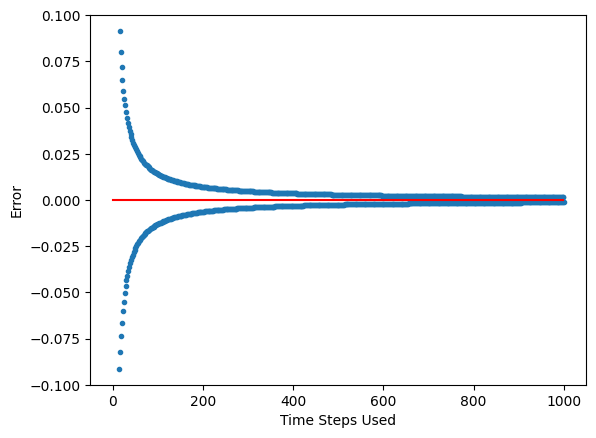

In [88]:
plt.scatter(range(1,1001),errors_am,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.1,0.1]);

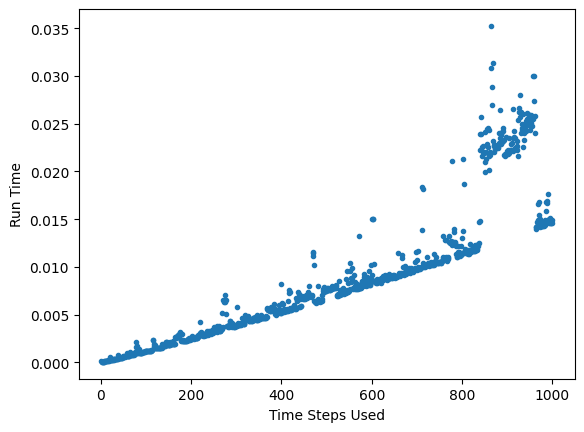

In [89]:
plt.scatter(range(1,1001),times_am,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

## Averaging

In [90]:
def american_averager(S_0,K,Maturity,sigma,N,r,q,is_call):
  a = american_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call)
  b = american_backward_induction(S_0,K,Maturity,sigma,N+1,r,q,is_call)
  avg = (a+b)/2
  return avg

In [94]:
errors_amavg = []
times_amavg = []
for i in range(1,1001):
  start = time.time()
  errors_amavg.append(american_averager(100,100,1,0.2,i,0.05,0.02,False)-6.66069)
  stop = time.time()
  times_amavg.append(stop-start)

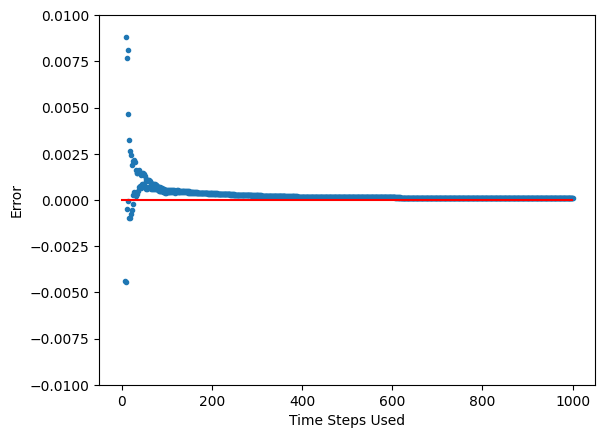

In [95]:
plt.scatter(range(1,1001),errors_amavg,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.01,0.01]);

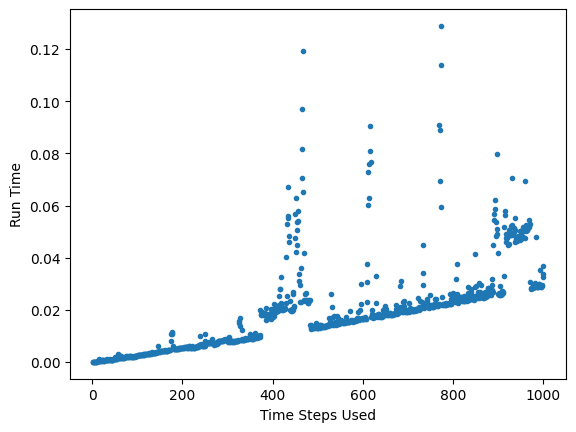

In [96]:
plt.scatter(range(1,1001),times_amavg,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");